<h3 style="text-align: center;"><b>Fashion MNIST</b></h3>

---

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

# Import Libraries

---

In [ ]:
# установим последнюю версию wandb
# !pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.6 MB/s eta 0:00:00


In [1]:
from collections import OrderedDict
import os
import random

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torch.utils.data import DataLoader
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import seaborn as sns
import matplotlib.pyplot as plt

import wandb # для логирования

from tqdm import *

%matplotlib inline

# Options

---

Зафиксируем seed для воспроизводимости:

In [2]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)


Задаем параметры нашего эксперимента:

In [5]:
class CFG:
  api = "..."
  project = "FashionMNIST"
  entity = "..."
  num_epochs = 10
  train_batch_size = 64
  test_batch_size = 512
  # num_workers = -1  # multiprocessing.cpu_count()
  lr = 0.01
  seed = 2023
  classes = 10
  wandb = False

Функция перевода класса конфигурации в словарь:

In [4]:
def class2dict(f_):
  return dict((name, getattr(f_, name)) for name in dir(f_) if not name.startswith('__'))

Среднее и стандартное отклонение необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

# Load data

---

In [6]:
def create_data_loaders() -> tuple:
    # будем загружать картинки, сразу преобразуя их в тензор и нормализуя
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2859,), (0.3530,))])

    train_data_ = datasets.FashionMNIST(
        root="data", 
        train=True,
        download=True, 
        transform=transform
    )
    test_data_ = datasets.FashionMNIST(
        root="data", 
        train=False,
        download=True, 
        transform=transform
    )

    train_loader_ = DataLoader(
        train_data_,
        batch_size=CFG.train_batch_size,
        shuffle=True,
        pin_memory=True
    )
    test_loader_ = DataLoader(
        test_data_,
        batch_size=CFG.test_batch_size,
        shuffle=True,
        pin_memory=True
    )
    return train_loader_, test_loader_


train_loader, test_loader = create_data_loaders()

Отрисуем несколько картинок:

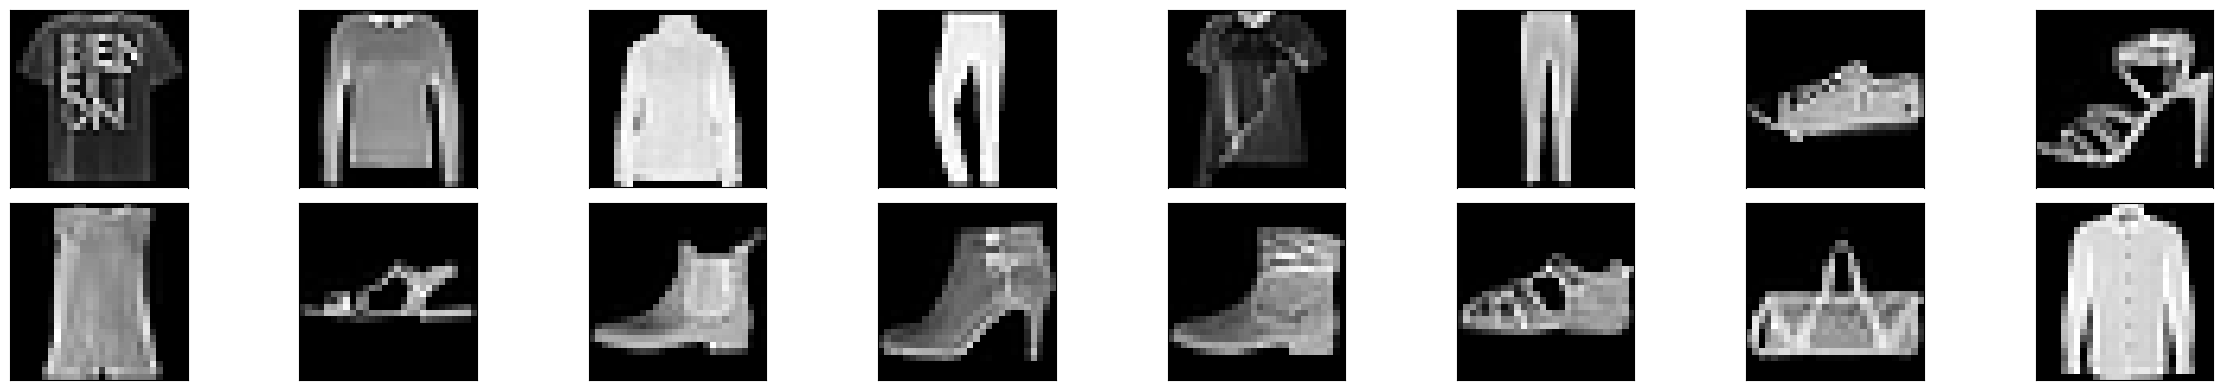

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    fig.add_subplot(2, 8, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(images[idx]), cmap="gray")
    plt.tight_layout()
plt.show()

# Fully connected neural network

---

Создаем полносвязаннную нейронную сеть:

In [8]:
class My_Net(nn.Module):
    def __init__(self) -> None:
        super(My_Net, self).__init__()

        self.pic_size = 28 * 28
        hidden_1 = 256
        hidden_2 = 128

        self.net = nn.Sequential(OrderedDict([
            ("linear_1", nn.Linear(self.pic_size, hidden_1)),
            ("relu_1", nn.ReLU()),
            ("linear_2", nn.Linear(hidden_1, hidden_2)),
            ("relu_2", nn.ReLU()),
            ("linear_3", nn.Linear(hidden_2, CFG.classes)),
            ("log_softmax", nn.LogSoftmax(dim=1))
        ]))

    def forward(self, x_: torch.Tensor) -> torch.Tensor:
        return self.net(x_.view(-1, self.pic_size))

In [9]:
def get_current_device() -> torch.device:
    device_ = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
    print("device: ", device_)
    return device_

Посмотрим на нашу модель:

In [10]:
model = My_Net()
model.to(get_current_device())
print(model)

device:  mps
My_Net(
  (net): Sequential(
    (linear_1): Linear(in_features=784, out_features=256, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=256, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=10, bias=True)
    (log_softmax): LogSoftmax(dim=1)
  )
)


In [11]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

## Visualize results

---

Функция для отображения картинки и предсказания модели:

In [134]:
def view_classify(img, ps):
    obj_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    
    img_ = img.cpu()
    ps = ps.data.cpu().numpy().squeeze()
    _, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)

    ax1.imshow(img_.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis("off")

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(obj_names, size="small")
    ax2.set_title("Class Probability")
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

## Train loop

---

Функция обучения модели:

In [135]:
def train(model_: My_Net, device_: torch.device, train_loader_, optimizer_, criterion_, WANDB) -> None:
    # обязательно переводим в режим обучения
    model_.train()
    
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader_), total=len(train_loader_)):
        # переводим картинки и таргеты на GPU
        data, target = data.to(device_), target.to(device_)

        # обнуляем градиенты!
        optimizer_.zero_grad()

        # прямой проход
        output = model_.forward(data)
        pred = output.argmax(dim=1, keepdim=True)

        # определяем корректность предсказания
        correct += pred.eq(target.view_as(pred)).sum().item()

        # считаем значение функции потерь
        train_loss = criterion_(output, target)

        # обратный проход
        train_loss.backward()

        # делаем градиентный шаг оптимизатором
        optimizer_.step()

    # считаем метрики и лосс
    tqdm.write("\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%".format(
        train_loss, 100. * correct / len(train_loader_.dataset)))

    if WANDB:
        wandb.log({
            "train_loss": train_loss,
            "train_accuracy": correct / len(train_loader_.dataset)
        })

## Realization of predict and calculate accuracy

---

Функция тестирования модели:

In [136]:
def test(model_: My_Net, device_: torch.device, test_loader_, criterion_, WANDB) -> None:
    # переводем модель в режим инференса
    model_.eval()

    test_loss = 0
    correct = 0
    
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader_:
            data, target = data.to(device_), target.to(device_)
            output = model_(data)

            # считаем значение функции потерь
            test_loss = criterion_(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            view_classify(data[0].view(1, 28, 28), F.softmax(output[0], dim=0))
    
    tqdm.write("Test set: Average loss: {:.4f}, Accuracy: {:.0f}%".format(
        test_loss, 100. * correct / len(test_loader_.dataset)))

    if WANDB:
        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": correct / len(test_loader_.dataset)
        })

Основная функция для экспериментов:

In [137]:
def main(model_, optimizer_, train_loader_, test_loader_, criterion_) -> None:
    seed_everything(CFG.seed)

    device = get_current_device()
    
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(
            project=CFG.project, 
            entity=CFG.entity, 
            reinit=True, 
            config=class2dict(CFG)
        )
        wandb.watch(model_, log="all")
    
    print("\nTraining start!")
    for epoch in range(1, CFG.num_epochs + 1):
        print("\nEpoch:", epoch)
        train(model_, device, train_loader_, optimizer_, criterion_, CFG.wandb)
        test(model_, device, test_loader_, criterion_, CFG.wandb)

    print("\nTraining end!")

In [ ]:
# if device.type == "cuda":
    # gpu_info = !nvidia-smi
    # gpu_info = '\n'.join(gpu_info)
    # print(gpu_info)

Wed Jan 18 00:58:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |    574MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model, optimizer, train_loader, test_loader, criterion)

Можем заметить основную проблему, а именно то, что сеть обращает слишком много внимания на детали и не умеет выделять общие признаки.

## Test different activation functions

---

Пробуем другие оптимизаторы:

In [ ]:
optimizers_lst = [
    torch.optim.Adagrad,
    torch.optim.Adadelta,
    torch.optim.Adam,
    torch.optim.AdamW,
    torch.optim.SparseAdam,
    torch.optim.Adamax,
    torch.optim.ASGD,
    # torch.optim.LBFGS,
    torch.optim.NAdam,
    torch.optim.RAdam,
    torch.optim.RMSprop,
    torch.optim.Rprop,
    torch.optim.SGD
]

for opt in optimizers_lst:
    model = My_Net()
    model.to(get_current_device())
    optimizer = opt(model.parameters(), lr=CFG.lr)
    print("-" * 50)
    print("\n", opt.__name__)
    train_loader, test_loader = create_data_loaders()
    try:
        main(model, optimizer, train_loader, test_loader, nn.CrossEntropyLoss())
    except Exception as e:
        print("Возникла ошибка:", e)
        print("Пропускаем оптимизатор", opt.__name__)
    print("\n" + "-" * 50)


Результаты сравниваем в таблице.

In [67]:
df = pd.read_csv("data/results.csv")
df.Epoch = df.Epoch.astype(int)
df

,Epoch,Type,Metric,Algorithm,Value
0,1,Train set,Average loss,Adagrad,0.3129
1,1,Train set,Accuracy,Adagrad,83.0000
2,1,Test set,Average loss,Adagrad,0.3200
3,1,Test set,Accuracy,Adagrad,86.0000
4,2,Train set,Average loss,Adagrad,0.2753
...,...,...,...,...,...
1315,29,Test set,Accuracy,SGD,88.0000
1316,30,Train set,Average loss,SGD,0.3228
1317,30,Train set,Accuracy,SGD,92.0000
1318,30,Test set,Average loss,SGD,0.3099


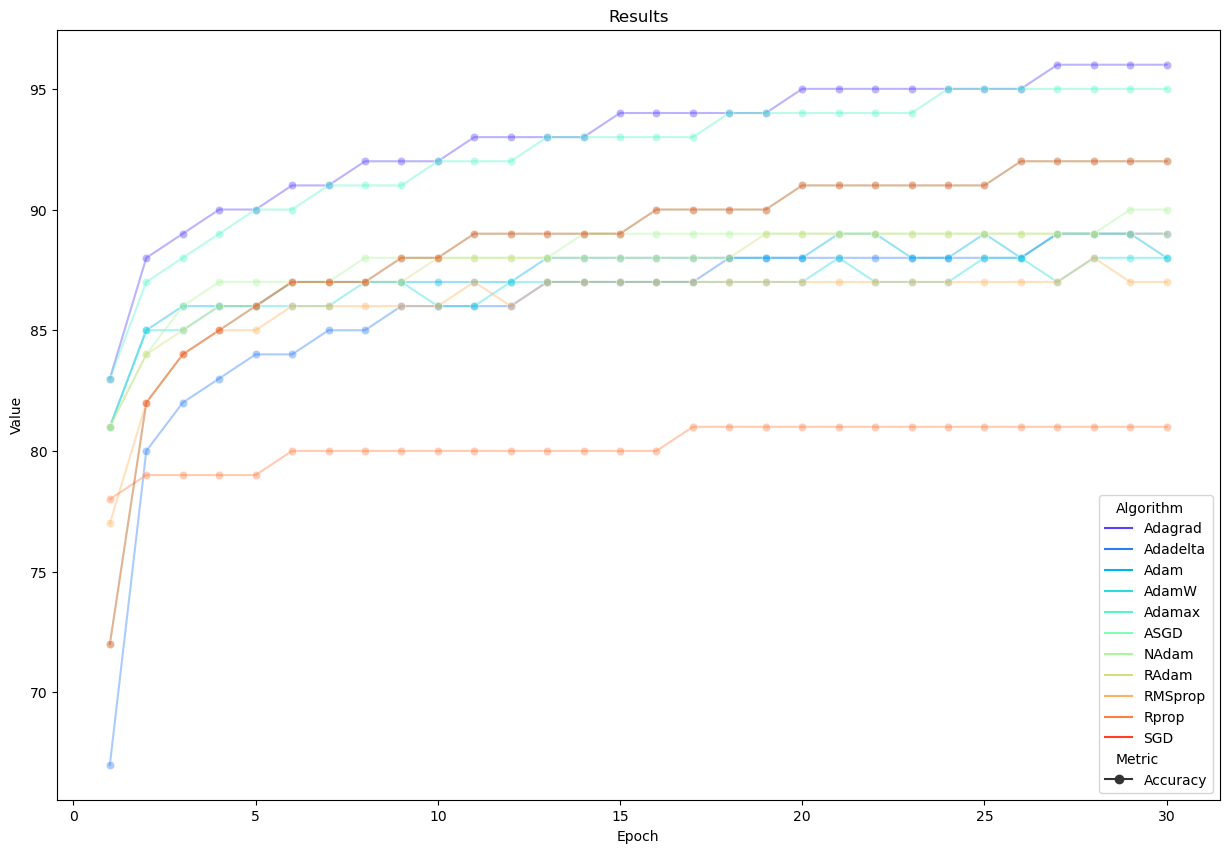

In [88]:
def plot_results(df_: pd.DataFrame) -> None:
    plt.figure(figsize=(15, 10))
    plt.title("Results")
    sns.lineplot(
        data=df_, 
        x="Epoch", 
        y="Value", 
        hue="Algorithm", 
        style="Metric", 
        markers=True, 
        dashes=False,
        palette="rainbow",
        alpha=0.4,
        legend="full"
    )
    plt.show()

plot_results(df[(df.Metric == "Accuracy") & (df.Type == "Train set")])

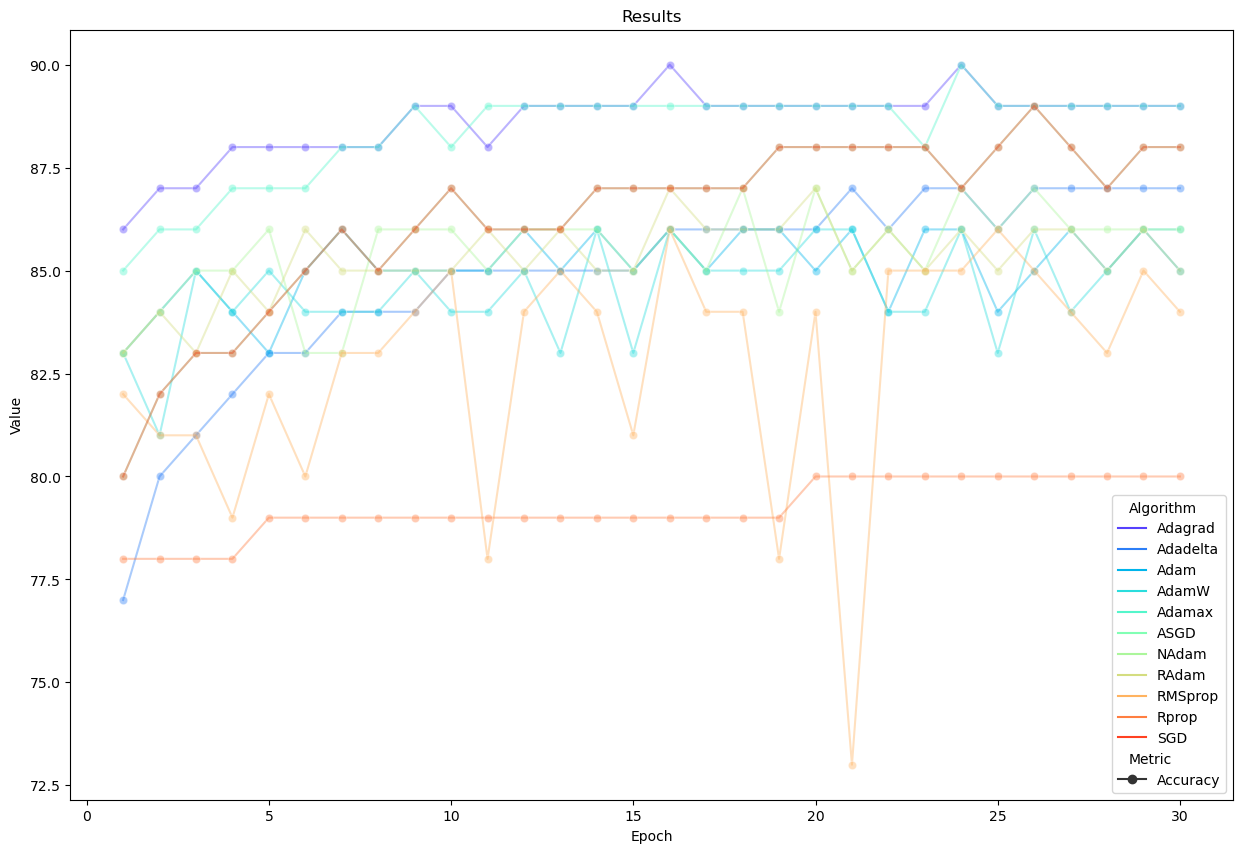

In [87]:
plot_results(df[(df.Metric == "Accuracy") & (df.Type == "Test set")])

По показателям accuracy и скорости сходимости определяем лучший оптимизатор.

1. По Accuracy лучший оптимизатор - Adagrad. Он 2 раза показал лучший результат на тестовой выборке. И единственный, кто на тренировочной выборке показал результат выше 95%. Рядом с ним идет Adamax, который показал результат 95% на тренировочной выборке. И даже 1 раз лучший результат на тестовой выборке. В среднем результаты очень похожи на Adagrad. На третье место можно поставить Rprop. Все остальные оптимизаторы показали результаты хуже 95% на обеих выборках.
2. По скорости сходимости в лидерах Adamax и Adagrad. Adagrad впервые достиг 90% на тестовой выборке на 16 эпохе. Adamax и Adagrad вместе достигли 90% на 24 эпохе.

Данный результат действителен для learning_rate = 0.01. При изменении learning_rate результаты могут измениться.

Пробуем добавить еще пару слоев:

In [12]:
class FCNet(nn.Module):
    def __init__(self) -> None:
        super(FCNet, self).__init__()

        self.pic_size = 28 * 28
        hidden_1 = self.pic_size // 2
        hidden_2 = hidden_1 // 2
        hidden_3 = hidden_2 // 2

        layers = [
            ("linear_1", nn.Linear(self.pic_size, hidden_1)),
            ("relu_1", nn.ReLU()),
            ("linear_2", nn.Linear(hidden_1, hidden_2)),
            ("relu_2", nn.ReLU()),
            ("linear_3", nn.Linear(hidden_2, hidden_3)),
            ("relu_3", nn.ReLU()),
            ("linear_4", nn.Linear(hidden_3, CFG.classes)),
            ("log_softmax", nn.LogSoftmax(dim=1))
        ]
        self.net = nn.Sequential(OrderedDict(layers))

    def forward(self, x_: torch.Tensor) -> torch.Tensor:
        return self.net(x_.view(-1, self.pic_size))


class NetLearning():
    def __init__(self, model_: FCNet, optimizer_: torch.optim) -> None:
        self.model = model_

        self.device = get_current_device()
        self.model.to(self.device)

        print("\n", optimizer_.__name__)
        self.optimizer = optimizer_(self.model.parameters(), lr=CFG.lr)

        self.train_loader, self.test_loader = create_data_loaders()

        self.criterion = nn.CrossEntropyLoss()
    
    def prep_pixels(self, train: np.ndarray, test: np.ndarray) -> tuple:
        return train.astype('float32') / 255, test.astype('float32') / 255
    
    def calc_accuracy(self, correct_: float, train_: bool = True) -> float:
        return correct_ / len(self.train_loader.dataset if train_ else self.test_loader.dataset)
    
    def start_wandb(self) -> None:
        if CFG.wandb:
            os.environ["WANDB_API_KEY"] = CFG.api
            wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
            wandb.watch(self.model, log="all")
    
    def write_log_to_wandb(self, loss_: float, accuracy_: float, train_: bool = True) -> None:
        if CFG.wandb:
            wandb.log({
                "train_loss" if train_ else "test_loss": loss_,
                "train_accuracy" if train_ else "test_accuracy": accuracy_
            })
    
    def write_tqdm(self, loss_: float, correct_: float, train_: bool = True) -> None:
        accuracy = self.calc_accuracy(correct_, train_)
        tqdm.write("\n{}: Average loss: {:.4f}, Accuracy: {:.0f}%".format(
            "Train set" if train_ else "Test set", loss_, 100. * accuracy
        ))
        self.write_log_to_wandb(loss_, accuracy, train_)
    
    def start_learn(self):
        seed_everything(CFG.seed)
        self.start_wandb()
        
        print("\nTraining start!")
        for epoch in range(1, CFG.num_epochs + 1):
            print("\nEpoch:", epoch)
            self.train()
            self.test()
        print("\nTraining end!")

    def train(self) -> None:

        def _make_train_step(data: torch.Tensor, target: torch.Tensor) -> tuple:
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model.forward(data)
            pred = output.argmax(dim=1, keepdim=True)
            train_loss = self.criterion(output, target)
            train_loss.backward()
            self.optimizer.step()
            return pred.eq(target.view_as(pred)).sum().item(), train_loss
    
        self.model.train()
        correct, train_loss = 0, 0
        for _, (train_data, train_target) in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            new_correct, train_loss = _make_train_step(train_data, train_target)
            correct += new_correct
        
        self.write_tqdm(train_loss, correct)

    def test(self) -> None:

        def _make_test_step(data: torch.Tensor, target: torch.Tensor) -> tuple:
            data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            test_loss = self.criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            return pred.eq(target.view_as(pred)).sum().item(), test_loss
        
        self.model.eval()
        correct, test_loss = 0, 0
        with torch.no_grad():
            for test_data, test_target in self.test_loader:
                new_correct, test_loss = _make_test_step(test_data, test_target)
                correct += new_correct

        self.write_tqdm(test_loss, correct, False)

In [165]:
NetLearning(FCNet(), torch.optim.Adam).start_learn()

device:  mps

 Adam

Training start!

Epoch: 1


100%|██████████| 938/938 [00:13<00:00, 70.18it/s]



Train set: Average loss: 0.4852, Accuracy: 80%

Test set: Average loss: 0.4448, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:10<00:00, 85.47it/s]



Train set: Average loss: 0.5264, Accuracy: 84%

Test set: Average loss: 0.4741, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:11<00:00, 82.13it/s]



Train set: Average loss: 0.4135, Accuracy: 86%

Test set: Average loss: 0.4003, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:11<00:00, 83.36it/s]



Train set: Average loss: 0.7465, Accuracy: 86%

Test set: Average loss: 0.4467, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:10<00:00, 92.31it/s]



Train set: Average loss: 0.2811, Accuracy: 86%

Test set: Average loss: 0.4224, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:10<00:00, 91.67it/s]



Train set: Average loss: 0.4106, Accuracy: 87%

Test set: Average loss: 0.4844, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:11<00:00, 81.59it/s]



Train set: Average loss: 0.2972, Accuracy: 87%

Test set: Average loss: 0.4419, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:10<00:00, 88.30it/s]



Train set: Average loss: 0.2989, Accuracy: 87%

Test set: Average loss: 0.4700, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:11<00:00, 84.88it/s]



Train set: Average loss: 0.3526, Accuracy: 87%

Test set: Average loss: 0.4204, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:10<00:00, 85.30it/s]



Train set: Average loss: 0.3175, Accuracy: 87%

Test set: Average loss: 0.3740, Accuracy: 85%

Training end!


Добавление слоя не дало ожидаемого результата. Поэтому оставляем сеть без изменений.